In [149]:
import torch
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np


In [150]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # mean and std for MNIST
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


In [151]:
#one hot encoding and crating custom dataset
def one_hot_encode(y, num_classes):
    return np.eye(num_classes)[y]

class MyDataset(Dataset):
    def __init__(self, data, label): 
        self.data = data
        self.labels = label 
        # self.labels = one_hot_encode(label, num_classes=10).astype(np.float32) # Old one-hot encoding

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx].float() / 255.0 
        x = (x - 0.1307) / 0.3081           
        y = self.labels[idx] # Return class index
        return x, y


        
    
X_train,y_train = train_dataset.data, train_dataset.targets
X_test,y_test = test_dataset.data,test_dataset.targets

train_d = MyDataset(X_train,y_train)
test_d = MyDataset(X_test,y_test)

train_loader = DataLoader(train_d, batch_size=64, shuffle=True)
test_loader = DataLoader(test_d,batch_size=64,shuffle=True)


In [163]:
for image,target in train_loader:
    print(target.shape)
    break

torch.Size([64])


In [153]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,padding=2,kernel_size=5,out_channels=6)
        self.maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.conv2 = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5)

        self.fc1 = nn.Linear(400,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)

        self.activation = nn.ReLU()

    
    def forward(self,x):

        x = self.maxpool(self.activation(self.conv1(x)))

        x = self.maxpool(self.activation(self.conv2(x)))

        x = x.view(-1,16*5*5)

        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)

        return x


In [154]:
model = LeNet()

In [179]:
model = model.to('cpu')
with torch.no_grad():
    # Assuming train_d[0][0] is a valid input tensor
    # Unsqueeze to add batch and channel dimensions
    output = model(train_d[0][0].unsqueeze(0).unsqueeze(0))
output

tensor([[-15.1190,  -6.7696, -13.0939,   4.4318, -15.2364,  15.0605,  -6.9203,
          -9.9531,  -2.6168,  -1.0315]])

In [164]:
def train(model,train_loader,optimizer,criterian,epochs,device):
    losses = []
    model.train()
    model = model.to(device)
    for epoch in range(epochs):
        running_loss = 0.0
        for images,labels in train_loader:
            optimizer.zero_grad()
            images = images.unsqueeze(1)
            images,labels = images.to(device),labels.to(device)
            output = model(images)
            loss = criterian(output,labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_epoch_loss = running_loss / len(train_loader) 
        losses.append(avg_epoch_loss) 
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_epoch_loss:.4f}")
    return losses # Return losses for plotting



In [156]:
optimizer = optim.Adam(model.parameters(), lr=0.001) # Adjusted learning rate
criterian = nn.CrossEntropyLoss()
device = "mps" if torch.mps.is_available() else "cpu"
training_history = train(model, train_loader,optimizer=optimizer,criterian=criterian,epochs=10,device=device) # Capture history

Epoch [1/10], Loss: 0.2415
Epoch [2/10], Loss: 0.0638
Epoch [2/10], Loss: 0.0638
Epoch [3/10], Loss: 0.0461
Epoch [3/10], Loss: 0.0461
Epoch [4/10], Loss: 0.0371
Epoch [4/10], Loss: 0.0371
Epoch [5/10], Loss: 0.0283
Epoch [5/10], Loss: 0.0283
Epoch [6/10], Loss: 0.0246
Epoch [6/10], Loss: 0.0246
Epoch [7/10], Loss: 0.0220
Epoch [7/10], Loss: 0.0220
Epoch [8/10], Loss: 0.0177
Epoch [8/10], Loss: 0.0177
Epoch [9/10], Loss: 0.0161
Epoch [9/10], Loss: 0.0161
Epoch [10/10], Loss: 0.0142
Epoch [10/10], Loss: 0.0142


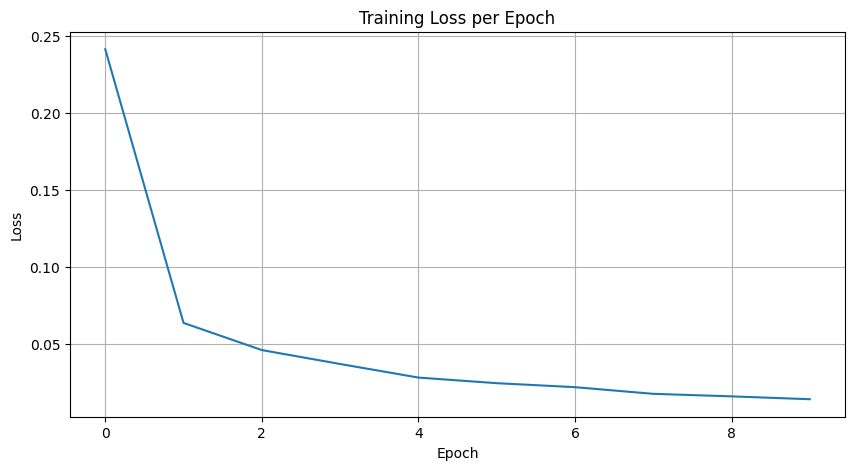

In [157]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(training_history)
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [ ]:
# Evaluate the model
def predict(model, raw_image_tensor): 
    model.eval()
    with torch.no_grad():
        processed_image = raw_image_tensor.float() / 255.0
        processed_image = (processed_image - 0.1307) / 0.3081
        processed_image = processed_image.unsqueeze(0).unsqueeze(0)  #(b,in_channels,h,w)
        processed_image = processed_image.to(device)  

        output = model(processed_image)
        _, predicted = torch.max(output, 1)
    return predicted.item()


predicted_label = predict(model, X_train[2])
print(f"Predicted label: {predicted_label}")
print(f"Actual label: {y_train[2]}")

Predicted label: 4
Actual label: 4


In [182]:
#calculate accuracy
def calculate_accuracy(model, data_loader, device):
    model.eval()
    model.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.unsqueeze(1).to(device)  
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total * 100
    return accuracy


# Calculating accuracy on training and test datasets
train_accuracy = calculate_accuracy(model, train_loader, device)
test_accuracy = calculate_accuracy(model, test_loader, device)

In [183]:
print(f"Training Accuracy: {train_accuracy:.2f}%")
print(f"Test Accuracy: {test_accuracy:.2f}%")

Training Accuracy: 99.71%
Test Accuracy: 99.05%


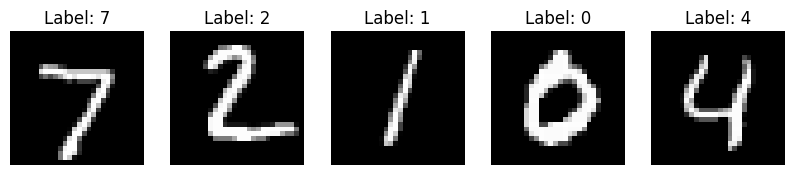

In [184]:
fig = plt.figure(figsize=(10, 5))



for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1)
    ax.imshow(X_test[i], cmap='gray')
    ax.set_title(f"Label: {y_test[i]}")
    ax.axis('off')

    

In [185]:
from sklearn.metrics import confusion_matrix

In [215]:
y_pred = []

with torch.no_grad():
    for images, labels in test_dataset:
        images = images.unsqueeze(1).to(device)  
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.append(predicted)

y_pred

[tensor([7], device='mps:0'),
 tensor([2], device='mps:0'),
 tensor([1], device='mps:0'),
 tensor([0], device='mps:0'),
 tensor([4], device='mps:0'),
 tensor([1], device='mps:0'),
 tensor([4], device='mps:0'),
 tensor([9], device='mps:0'),
 tensor([5], device='mps:0'),
 tensor([9], device='mps:0'),
 tensor([0], device='mps:0'),
 tensor([6], device='mps:0'),
 tensor([9], device='mps:0'),
 tensor([0], device='mps:0'),
 tensor([1], device='mps:0'),
 tensor([5], device='mps:0'),
 tensor([9], device='mps:0'),
 tensor([7], device='mps:0'),
 tensor([3], device='mps:0'),
 tensor([4], device='mps:0'),
 tensor([9], device='mps:0'),
 tensor([6], device='mps:0'),
 tensor([6], device='mps:0'),
 tensor([5], device='mps:0'),
 tensor([4], device='mps:0'),
 tensor([0], device='mps:0'),
 tensor([7], device='mps:0'),
 tensor([4], device='mps:0'),
 tensor([0], device='mps:0'),
 tensor([1], device='mps:0'),
 tensor([3], device='mps:0'),
 tensor([1], device='mps:0'),
 tensor([3], device='mps:0'),
 tensor([4

In [216]:
my_arr = torch.cat(y_pred).cpu().numpy()
my_arr

array([7, 2, 1, ..., 4, 5, 6], shape=(10000,))

In [217]:
cf = confusion_matrix(y_test,my_arr)

In [218]:
from seaborn import heatmap

<Axes: >

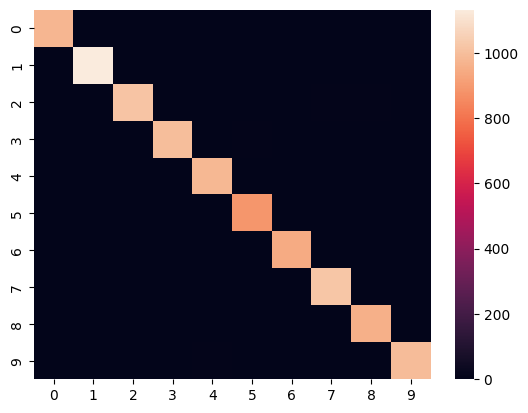

In [219]:
heatmap(cf)